# Development - Pasiphae survey: strategy

This notebook is not primarily a demonstration of the survey strategy, but follows through the steps of developing and implementing the survey strategy.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.coordinates import AltAz, Angle, EarthLocation, get_sun, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmasher as cmr
import matplotlib.cm as cm
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
import numpy as np
import os
from sklearn.neighbors import NearestNeighbors
import sqlite3

import constraints as c
from db import DBConnectorSQLite
from skyfields import Field, SkyFields
from surveyplanner import ObsWindow, Telescope, SurveyPlanner
import visualizations as viz

In [3]:
plt.style.use('file:///home/skiehl/Projects/Python/Scripts/mypackages/mplstyles/notebook.mplstyle')

## Outline of the survey strategy

1. The sky is divided into fields. The field size is dictated by the instruments field-of-view (FoV). WALOP-N and -S will have different FoV. Thus, the field grid will differ in the northern and southern hemisphere. As a consequence, fields are tied to 1. specific instrument. The field grid is developed in the notebook `SkyFields.ipynb`.
1. The survey strategy defines how fields are selected for observations.
    1. We use two main prioritization schemes:
        1. Coherence in sky coverage: select field close to other fields already done.
        1. Source observability: prefer e.g. fields that are rising or setting soon.
    1. We will apply a weighting between the two schemes.
1. A database is used to store the fields, the field observability windows, observations associated with the fields, and all other information required for the survey planning.

## Create test grid

In this notebook we develop the different parts of the survey strategy. Note that we do not use the actual Pasiphae field grid, but a very coarse grid to reduce the computing time.

In [6]:
# north:
fov = np.radians(8.)
overlap = np.radians(2.)
tilt = np.radians(0.)
b_lim = np.radians(30.)
dec_lim_south = np.radians(-10.)

fields_north = SkyFields(fov, overlap, tilt=tilt, b_lim=b_lim, dec_lim_south=dec_lim_south)
print('\n', fields_north)

Creating fields..
Done.                              

 SkyFields
Field of view:     8.0000 deg
Overlap            2.0000 deg
Tilt:             +0.0000 deg
Gal. lat. lim:    30.0000 deg
Dec. lim. N:      None
Dec. lim. S:      -10.0000 deg
Number of fields: 323


In [7]:
# south:
fov = np.radians(10.)
overlap = np.radians(2.)
tilt = np.radians(0.)
b_lim = np.radians(30.)
dec_lim_north = np.radians(10.)

fields_south = SkyFields(fov, overlap, tilt=tilt, b_lim=b_lim, dec_lim_north=dec_lim_north)
print('\n', fields_south)

Creating fields..
Done.                              

 SkyFields
Field of view:    10.0000 deg
Overlap            2.0000 deg
Tilt:             +0.0000 deg
Gal. lat. lim:    30.0000 deg
Dec. lim. N:      10.0000 deg
Dec. lim. S:      None
Number of fields: 195


### Show grid

The `FieldGridVisualizer` class from the `visualization` module provides two methods to plot the field outlines either in an orthographic or in a Mollweide projection. The fields can be provided either during the class initialization or when calling either method.

In [8]:
fgv = viz.FieldGridVisualizer(fields_north, fields_south)

#### Grid in orthographic projection

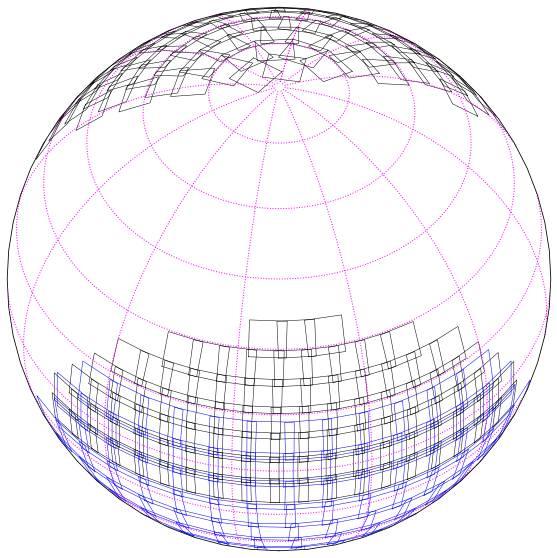

In [9]:
fgv.orthographic(10, 45);

#### Grid in Mollweide projection

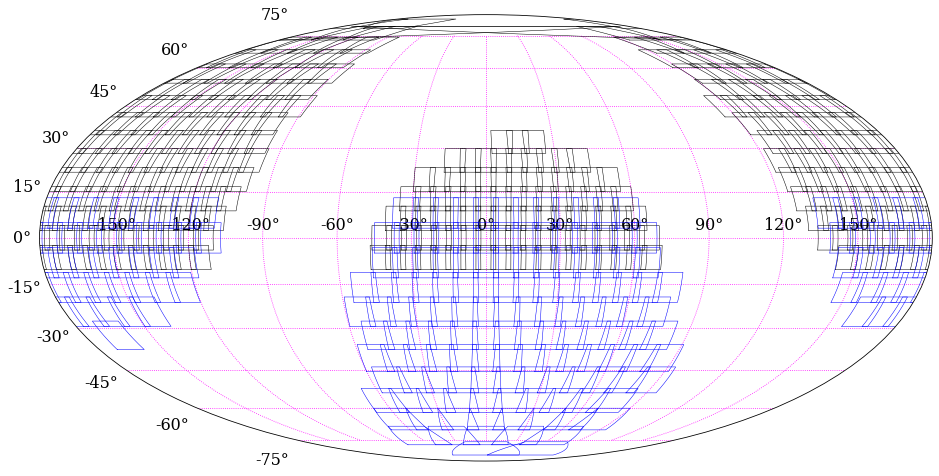

In [10]:
fgv.mollweide();

## Database 

### Database schema

**Note:** The goal is to base the Pasiphae survey planner / observation planner on the TOM-toolkit. For development of the survey planner I find it easier to work with a simple data base structure rather than figuring out the database and code implementation of the TOM-toolkit first. Therefore, I will use my own database schema for the concept development.

#### Observatories

The `Observatories` table contains the basic information about the observatories.

| table Observatories | | |
|---|---|---|
| observatory_id | int | Unique identifier. |
| lat | float | Latitude in rad. |
| lon | float | Longitude in rad. |
| heigth | float | Height in meters. |
| utc_offset | float | UTC_offset during normal time. |

#### Parameter sets

Observation windows (time periods when a source is observable) need to be calculated for a specific set of constraints. Those can be (i) the technical constraints specific for a telescope like hourangle limits, (b) observational constraints like separtion from the Moon and airmass limit, as well as (c) the definition of night start, e.g. astronomical twilight. If we change anything for such a set, precalculated `ObsWindows` are not applicable anymore. Therefore, ObsWindows need to be tied to a set of constraints. Therefore, we need to store those sets, the related constraints, and the parameters for those constraints in the database.

The `ParameterSet` table contains parameter sets. A set is a complete compilation of all constraints applied to calculate the observation windows. A set is tied to one observatory. A set cannot be changed. Only one set per observatory can be the active set.

| table ParameterSet | | |
|---|---|---|
| parameter_set_id | int | Unique identifier. |
| observatory_id | int | ID of the related observatory. |
| active | bool | Only the active parameter set is used. |
| date | datetime | Date when the parameter set was added. |

#### Constraints

The `Constraints` table lists all constraints. This table relates the parameters to the specific constraint class. All constraint classes defined in the `constraints.py` module need to be defined in the database and the `constraint_name` in the database must match that of the corresponding constraint in `constraints.py`. **Note:** The definition of the used twilight is a constaint on the observations, but not a Constraint class; nevertheless it will be added to this table. Whereas constraints are optional (even though in reality every observatory will have some constraints), the definition of twilight will be a necessary constraint in the context of the Pasiphase survey. (For radio telescopes this would not be the case, but we are not developing a general use target and observation manager.)

| table Constraints | | |
|---|---|---|
| constraint_id | int | Unique identifier. |
| constraint_name | char | Name of the observational constraint. |

<div class="alert alert-block alert-info">
    <b>Note:</b> This is a critical point, because any changes made in <span style="font-family:mono">constraints.py</span> need to be implemented in the database interface as well. 
</div>

#### Parameters

The `Parameters` table contains all parameters associated with added constraints. A constraint may require multiple parameters. Therefore, the `parameter_name` needs to match the corresponding argument of the class initialization. **Note:** Through the use of argument names instead of argument positions the relation between the `constraints.py` module and the database is less error prone, because changes in the order of arguments will not result in errors.

| table Parameters | | |
|---|---|---|
| parameter_id | int | Unique identifier. |
| constraint_id | int | ID of the associated constraint. |
| parameter_set_id | int | ID of the associated parameter set. |
| parameter_name_id | int | ID of the corresponding argument name in the associated class initialization. |
| value | float | Numerical value. |
| svalue | char | String value. |

#### Parameter names

To avoid many dublications of parameter names in the above table, parameter names will be defined in the `ParameterNames` table and referenced through an ID.

| table ParameterNames | | |
|---|---|---|
| parameter_name_id | int | Unique identifier. |
| parameter_name | char | Parameter name corresponding to argument name in the associated class initialization. |

#### Fields

The `Fields` table contains the main information about fields. A field is directly associated with an observatory. WALOP North and South will have different field-of-view and, thus, will require different sky grids, even in the overlapping region. Therefore, a field will be related to one specific observatory. The `active` column will state whether a field should be scheduled or not. If we want to discard fields we can set them inactive rather than deleting those entries. The `jd_next_obs_window` column stores the latest JD up to which observation windows have been calculated. For sources with seasonal availability the latest stored observation window may not be on the latest date for which the windows were calculated. To avoid calculating windows over and over again for dates when the source is not available it is necessary to store the date for which the latest calculation was done.

| table Fields | | |
|---|---|---|
| field_id | int | Unique identifier. |
| fov | Field of view in rad. |
| center_ra | float | Right ascension in rad. |
| center_dec | float | Declination in rad. |
| tilt | Field tilt in rad. |
| observatory_id | int | ID of associated observatory. |
| active | bool | Only active fields will be scheduled. |
|jd_next_obs_window | float | JD of the latest caculated obs window. |

#### Observation windows

The `ObsWindows` table contains the information when fields are observable. The calculation of ObsWindows is described above. **Note:** ObsWindows relate to a specific field and through that to a specific observatory. However, they also depend on the specified set of constraints. If the constraints are changed, ObsWindows need to be recalculated. Former ObsWindows need to be set inactive and must not be used in the survey/observation planning.

| table ObsWindows | | |
|---|---|---|
| obswindow_id | int | Unique identifier. |
| field_id | int | ID of the assiciated field. |
| date_start | datetime | Date and time when the field becomes observable. |
| date_stop | datetime | Date and time when the field stops to be observable. |
| duration | float | Duration of the observable window in hours. |
| active | bool | Only active ObsWindows will be taken into consideration. |

#### Observations

The survey planner will not schedule fields, it will actually schedule observations. Thus, we need a table with observations that are associated with fields. The `Observations` table lists observations of fields, including all information required for the observation - exposure time, repetitions, filters. This approach of scheduling observations and not fields allows us to repeat field observations, e.g. when an observation was of poor quality. We can simply add a new observation to the data base without affecting the `Fields` table. Furthermore, we can add multiple observations of the same field e.g. with different filters, etc.

| table Observations | | |
|---|---|---|
| observation_id | int | Unique identifier. |
| field_id | int | ID of the observed field. |
| exposure | float | Duration of the exposure. |
| repetitions | int | Number of repetitions. |
| filter_id | int | ID of the filter selected for the exposure. |
| scheduled | bool | True, if the observation has been scheduled. False, otherwise.|
| done | bool | True, if the observation has been carried out. False, otherwise.|
| date | datetime | Date and time of the observation. |

#### Filters

The `Filters` table contains all the available filters. Rather than writing the filter directly to the `Observations` table as a string, having a `Filters` table allows to check if a filter is available, when observations are added.

| table Filters | | |
|---|---|---|
| filter_id | int | Unique identifier. |
| filter | str | Filter name. |

#### Reductions

The `Reductions` table lists which fields have been reduced.

| table Reductions | | |
|---|---|---|
| reduction_id | int | Unique identifier. |
| field_id | int | ID of the associated field. |
| reduction_date | datetime | Date and time of the reduction. |

<div class="alert alert-block alert-info">
<b>Note:</b> This will be of interest to visualize the survey progress. For the current development of the survey planner it is not relevant. Therefore, I will not include it in the database yet.
</div>

#### Surveys

The `Surveys` table

<div class="alert alert-block alert-info">
<b>Note:</b> Observations could be associated with different surveys - e.g. PHASIPHAE-N, PASIPHAE-S, PHAESTOS -, where the same observation could be associated with multiple surveys. It would be useful to have a Surveys table. This would allow us to visualize the progress of specific surveys. Also it could allow us to schedule observations for specific surveys - e.g. the optimal selection of sources for PASIPHAE and PHAESTOS could be different, but one should be prioratized momentarily.
</div>

### Database interface

#### Create data base

In [11]:
db = DBConnectorSQLite('test_planner.sqlite3')
db.create_db()

Database 'test_planner.sqlite3' created.
Table 'Fields' created.
Table 'Observatories' created.
Table 'ParameterSet' created.
Table 'Constraints' created.
Table 'Parameters' created.
Table 'ParameterNames' created.
Table 'ObsWindows' created.
Table 'Observations' created.
Table 'Observations' created.
Constraints added to table 'Constraints'.


#### Add and query telescopes

In [12]:
name = 'Skinakas'
lat = Angle('35:12:43 deg')
lon = Angle('24:53:57 deg')
height = 1750.
utc_offset = 2.
db.add_observatory(name, lat.rad, lon.rad, height, utc_offset)

Observatory 'Skinakas' added.


In [13]:
name = 'Sutherland'
lat = Angle('-32:22:46 deg')
lon = Angle('20:48:38.5 deg')
height = 1798.
utc_offset = 2.
db.add_observatory(name, lat.rad, lon.rad, height, utc_offset)

Observatory 'Sutherland' added.


Get observatory from data base by name:

In [14]:
telescope = db.get_observatory('Skinakas')
print('\n', telescope, sep='')


{'telescope_id': 1, 'name': 'Skinakas', 'lat': <Quantity 0.61456437 rad>, 'lon': <Quantity 0.43457244 rad>, 'height': 1750.0, 'utc_offset': 2.0}


#### Add and query constraints

Add constraints for each observatory:

In [15]:
twilight = 'nautical'
airmass_limit = c.AirmassLimit(2.)
moon_distance = c.MoonDistance(10.)

db.add_constraints('Skinakas', twilight, constraints=(airmass_limit, moon_distance))
db.add_constraints('Sutherland', twilight, constraints=(airmass_limit, moon_distance))

Get currently active constraints and corresponding parameters for one observatory:

In [16]:
db.get_constraints('Skinakas')

{'Twilight': {'twilight': -12.0},
 'AirmassLimit': {'limit': 2.0, 'conversion': 'secz'},
 'MoonDistance': {'limit': 10.0}}

#### Add and query fields

Add fields for Skinakas telescope:

In [79]:
db.add_fields(fields_north, 'Skinakas', active=True)

194 fields added to database.                   


Add fields for Sutherland telescope:

In [80]:
db.add_fields(fields_south, 'Sutherland', active=True)

100 fields added to database.                   


Get all fields:

In [81]:
fields = db.get_fields(active=True)
print('Number of fields:', len(fields))

Number of fields: 294


Get fields for specified observatory:

In [82]:
fields = db.get_fields(observatory='Skinakas', active=True)
print('Number of fields:', len(fields))

Number of fields: 194


**Note:** The database interface comprises more features than described above. These features are closely tied to the following parts of development and are therefore explained in the following.

## Field availability

For the source observability we need to know:

1. For how many nights is the target observable during a year?
1. At a given date for how many nights will the target remain observable?
1. For how long is a target observable at a given night? (do we really need this?)

Targets that will not be available anymore soon and targets that are generally only observable for a short period of time should be prioratized.

For that we need to calculate, when targets are observable. In the following we will call a period of time during which a target is continuously observable *observing window*. We will calulate the obs. windows for all targets for each night and for a certain time into the future. The obs. windows will be stored in the data base. The reason is that those calculations are time intensive and will be needed again by the observation planner. Rather than re-calculating obs. windows, we will store them once calculated.

**Note:** The following sections [4.1](#setup_tel) and [4.2](#obs_window_field) are a demonstration how the obs window calculation is done for a specific field during one night. These procedures are implemented in `surveyplanner.py` and the calculation through the surveyplanner module is demonstrated in section [4.3](#obs_window_fields).

<a id='setup_tel'></a>
### Set up telescope and constaints

Read telescope details from database and create `Telescope` instance:

In [17]:
db = DBConnectorSQLite('test_planner.sqlite3')

In [18]:
telescope = db.get_observatory('Skinakas')
telescope = Telescope(
        telescope['lat'], telescope['lon'], telescope['height'], telescope['utc_offset'], name=telescope['name'])
print(telescope)

Telescope: Skinakas created.
Telescope 
Name: Skinakas
Lat:     +35.2119 deg
Lon:      24.8992 deg
Height:   1750.00 m
UTC offset:  2.00 hours



Read constraints from database:

In [19]:
constraints = db.get_constraints('Skinakas')
print(constraints)

{'Twilight': {'twilight': -12.0}, 'AirmassLimit': {'limit': 2.0, 'conversion': 'secz'}, 'MoonDistance': {'limit': 10.0}}


Read the twilight definition (i.e. Sun declination at which the night 'starts') from the `constraints`-dictionary:

In [20]:
twilight = constraints['Twilight']['twilight']
print(twilight)

-12.0


Remove the `'Twilight'` entry from the dictionary. All remaining entries are telescope specific observational constraints:

In [21]:
del constraints['Twilight']

(1) Parse the constraints names, parameter names, and parameter values into executable code, (2) create the corresponding constraint class instances, and (3) add them to the `telescope`-instance:

In [22]:
for constraint_name, params in constraints.items():
    
    # parse constraint code:
    text = f"c.{constraint_name}("
    
    for arg, val in params.items():
        if isinstance(val, str):
            text += f"{arg}='{val}', "
        else:
            text += f"{arg}={val}, "
    
    if text[-1] == "(":
        text += ")"
    else:
        text = f"{text[:-2]})"
    
    print(text)
    
    # evaluate code and add constraint to telescope:
    constraint = eval(text)
    telescope.add_constraint(constraint)

c.AirmassLimit(limit=2.0, conversion='secz')
Constraint added: Airmass limit: 2.00
c.MoonDistance(limit=10.0)
Constraint added: Moon distance: 10.00 deg


<a id='obs_window_field'></a>
### Calculate observing windows for a field

In [23]:
time_sunset, time_sunrise = telescope.get_sun_set_rise(2022, 5, 1, twilight)
night_duration = time_sunrise - time_sunset
print(time_sunset + telescope.utc_offset)
print(time_sunrise + telescope.utc_offset)
print(night_duration.to(u.hour))

2022-05-01T20:05:58.619
2022-05-02T04:28:33.739
8.376422136438745 h


Create time steps between Sun set and rise and create `AltAz`-frame for the telescope:

In [24]:
time_interval = 10. * u.min
frame = telescope.get_frame(time_sunset, time_sunrise, time_interval)

Calculate obs. window for one field. The result is given as a tuple of `Time` objects giving the times when the field starts and stops to be observable. We can convert the tuple to an `ObsWindow` object:

In [25]:
fields = db.get_fields(observatory='Skinakas')
field = fields[10]
fov = field[1]
center_ra = field[2]
center_dec = field[3]
tilt = field[4]
field_id = field[6]
field = Field(fov, center_ra, center_dec, tilt, field_id=field_id)
obs_window = field.get_obs_window(telescope, frame, refine=1*u.min)[0]
obs_window = ObsWindow(*obs_window)
print(obs_window)

ObsWindow
Start: 2022-05-01T18:05:58.619
Stop:  2022-05-01T20:58:58.619
Duration: 2.88 h


Test another field:

In [26]:
fields = db.get_fields(observatory='Skinakas')
field = fields[20]
fov = field[1]
center_ra = field[2]
center_dec = field[3]
tilt = field[4]
field_id = field[6]
field = Field(fov, center_ra, center_dec, tilt, field_id=field_id)
obs_window = field.get_obs_window(telescope, frame, refine=1*u.min)[0]
obs_window = ObsWindow(*obs_window)
print(obs_window)

ObsWindow
Start: 2022-05-01T20:36:58.619
Stop:  2022-05-02T02:25:58.619
Duration: 5.82 h


<a id="obs_window_fields"></a>
### Calculate observing windows for all fields

At this stage we introduce the `SurveyPlanner` class, which implements the overall survey strategy. The strategy and its implementation is discussed in section [5](#survey_strategy). Here, we first calculate observing windows for all fields stored in the database. Those observing windows are then automatically stored in the database.

We start by creating a `SurveyPlanner` instance, accessing the database we created above:

In [4]:
surveyplanner = SurveyPlanner('test_planner.sqlite3')

The `add_obs_windows()` methods is used to calculate and add observing windows for all fields. The required first argument of the method is the date until which daily observation windows should be calculated. It needs to be given as `astropy.time.Time` object. The optional argument `date_start` also requires an `astropy.time.Time` object and sets the date from which on observing windows will be calculated. If no start date is provided, the current date will automatically be used as start date.

Unless the database has only been initialized, each field will have a JD stored that saves up to which JD (00:00:00 UTC) observing windows have already been calculated. There are various options that will be checked for each field separately:

1. If the stop date is earlier than the stored date and/or the start date, the field is simply skipped.
1. If the start date is earlier than the stored date, the observing window calculation will start with the stored date.
1. If the start date is later than the stored date, the user will be asked whether or not to continue. If not, the method is aborted entirely and no observing windows will be calculated and stored. If yes, observing windows will be calculate from the start date onwards. This implies that there will be a gap in stored observing windows. The time between the latest stored JD and the new start date will not be covered.
1. Otherwise, observing windows will be calculated between the last stored date and the stop date.

Calculate observing windows for a given time range:

In [85]:
#surveyplanner.add_obs_windows(Time('2022-04-30'))
surveyplanner.add_obs_windows(Time('2023-01-01'), date_start=Time('2022-02-01'))

Calculate observing windows until 0..
Observatory 1 of 2 selected: Skinakas
Telescope: Skinakas created.
Constraint added: Airmass limit: 2.00
Constraint added: Moon distance: 10.00 deg
Field 194 of 194 (100%)   
Observatory 2 of 2 selected: Sutherland
Telescope: Sutherland created.
Constraint added: Airmass limit: 2.00
Constraint added: Moon distance: 10.00 deg
Field 100 of 100 (100%)   
Calculating observing windows done.


### Selection of available fields

Once observing windows are calculated, we can query fields that are observable at a specific time or during a specific night.
The `SurveyPlanner` class allows to get an iterator or a complete list of observable fields. All options are demonstrated below.

#### Select fields available at given time

To get all fields observable at a given time, we and an `astropy.time.Time` object to the `datetime` argument.

Below we use the method that returns an interator, print the first field and its observing window, and then stop the iteration:

In [25]:
datetime = Time('2022-05-20T01:00:00')

for field in surveyplanner.iter_observable_fields('Skinakas', datetime=datetime, active=True):
    print(field)
    for obs_window in field.obs_windows:
        print(obs_window)
    break

Sky field 21
Field of view: 600.0000 arcmin
Center RA:     237.2727 deg
Center Dec:     -8.1818 deg
Tilt:           +0.0000 deg
Status:        plateauing

ObsWindow
Start: 2022-05-19 19:25:47.423
Stop:  2022-05-20 01:14:47.423
Duration: 5.82 h


Similarly, we use the method that returns a list of all observable fields. Below we just print the number of observable fields:

In [34]:
print('Fields available at Skinakas:   {0:3d}'.format(
        len(surveyplanner.get_observable_fields('Skinakas', datetime=datetime, active=True))))
print('Fields available at Sutherland: {0:3d}'.format(
        len(surveyplanner.get_observable_fields('Sutherland', datetime=datetime, active=True))))

Fields available at Skinakas:    60
Fields available at Sutherland:   6


#### Select fields available during given night

To get all fields observable during given night, we hand an `astropy.time.Time` object to the `night` argument. Note that the specified time object needs a date only. Any additional time information will be stripped automatically. This method will search for fields that are observable during the night that starts on the given day and ends on the next day. The UTC-offset of the specified observatory is automatically taken care of.

Below we use the method that returns an interator, print the first field and its observing window, and then stop the iteration:

In [35]:
night = Time('2022-05-15')

for field in surveyplanner.iter_observable_fields('Skinakas', night=night, active=True):
    print(field)
    for obs_window in field.obs_windows:
        print(obs_window)
    break

Sky field 10
Field of view: 600.0000 arcmin
Center RA:     147.2727 deg
Center Dec:     -8.1818 deg
Tilt:           +0.0000 deg
ObsWindow
Start: 2022-05-15 18:19:57.928
Stop:  2022-05-15 19:30:57.928
Duration: 1.18 h


Similarly, we use the method that returns a list of all observable fields. Below we just print the number of observable fields:

In [36]:
print('Fields available at Skinakas:   {0:3d}'.format(
        len(surveyplanner.get_observable_fields('Skinakas', night=night, active=True))))
print('Fields available at Sutherland: {0:3d}'.format(
        len(surveyplanner.get_observable_fields('Sutherland', night=night, active=True))))

Fields available at Skinakas:   150
Fields available at Sutherland:  31


### Status of field availability

When fields are selected their availability status is automatically detemined. For that, observing windows need to be available up to seven days into the future of the requested date and three days back. The duration of the nightly observing windows is then fitted with a linear function. There are five options:

| Status | Description | Criteria |
|-|-|-|
| **Not observable:** | Technically, this is a possible status of a field, though it will never occure among the selected fields, which are selected such that they are observable. | Zero oberving windows. |
| **Rising:** | The field is rising. The duration of time during which the field is observable currently increases from night to night. | Linear fit. p-value < 0.01, slope > 0. |
| **Plateauing:** | The duration of time during which the field is observable is currently constant. | Linear fit. p-value >= 0.01. |
| **Setting:** | The field is setting. The duration of time during which the field is observable currently decreases from night to night. | Linear fit. p-value < 0.01, slope < 0. |
| **Undetermined:** | The field status is currently unclear. This may be the case when the field just started rising above the elevation limit, or is about to set soon, or when observation windows have not been calculated far enough into the future. If there are too few data points for a linear fit, the status remains undetermined. | Fewer than four observing windows available. |


### Duration of availability of setting fields

When a field is identified as setting the number of nights for which it will remain observable is automatically calculated. This number is extrapolated from the linear fit to the duration of nightly observing window, when the slope is negative, i.e. the field is setting.

### Visualizations of field availability

The `FieldAvailabilityVisualizer` class from the `visualizations` module provides several methods to show the availability of fields. The available fields at a given day need to be called from the `surveyplanner` before. These fields can be handed to the `FieldAvailabilityVisualizer` either, when the class is initialized or when any of the methods is called.

In [5]:
night = Time('2022-06-20')
fields = surveyplanner.get_observable_fields('Skinakas', night=night, active=True)

In [6]:
fav = viz.FieldAvailabilityVisualizer(fields)

#### Duration of availability I

Here, the duration for which each field is available is shown in hours.

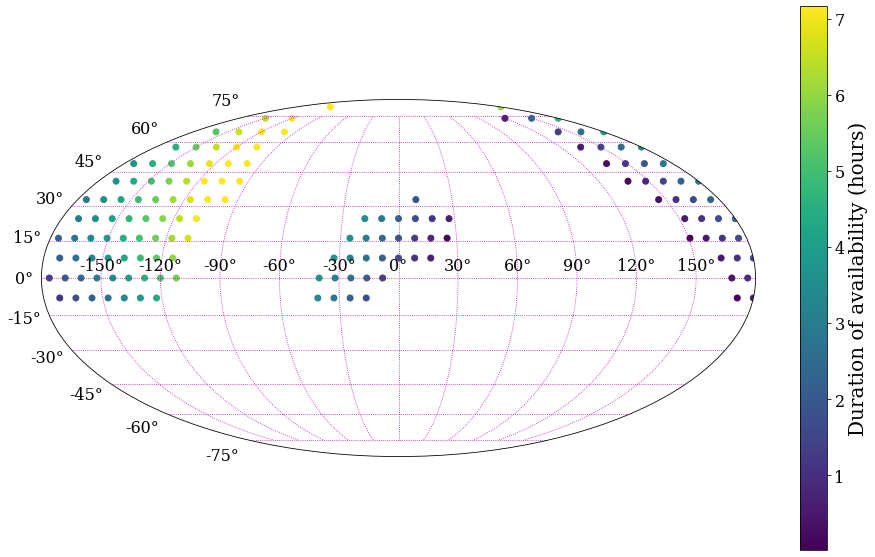

In [7]:
fav.field_duration();

#### Duration of availability II

We can get the night start and end from the `surveyplanner` and calculate the duration of the night. When the night duration is handed to the `field_duration` method each field's duration of availability is devided by the night duration, i.e. the plot shows the fraction of the night during which the fields are available. Note that the same date time needs to be used, when the available field and the night start and end are called from the `surveyplanner`, otherwise the plot is nonsensical.

In [61]:
night_start, night_end = surveyplanner.get_night_start_end('Skinakas', night)
night_duration = night_end - night_start

Telescope: Skinakas created.


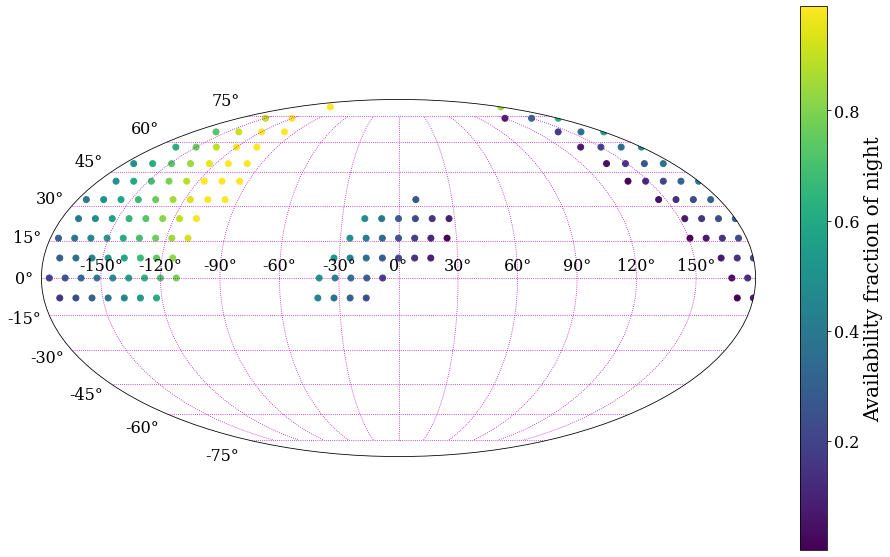

In [64]:
fav.field_duration(night_duration=night_duration);

#### Field status

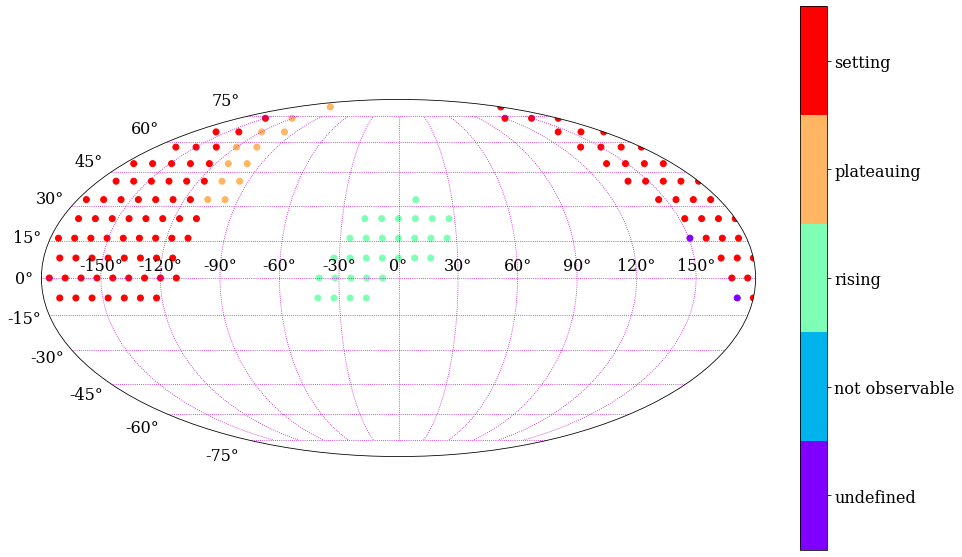

In [50]:
fav.field_status();

#### Duration until the fields are setting

This plot only shows setting sources. The duration until they set is given in days.

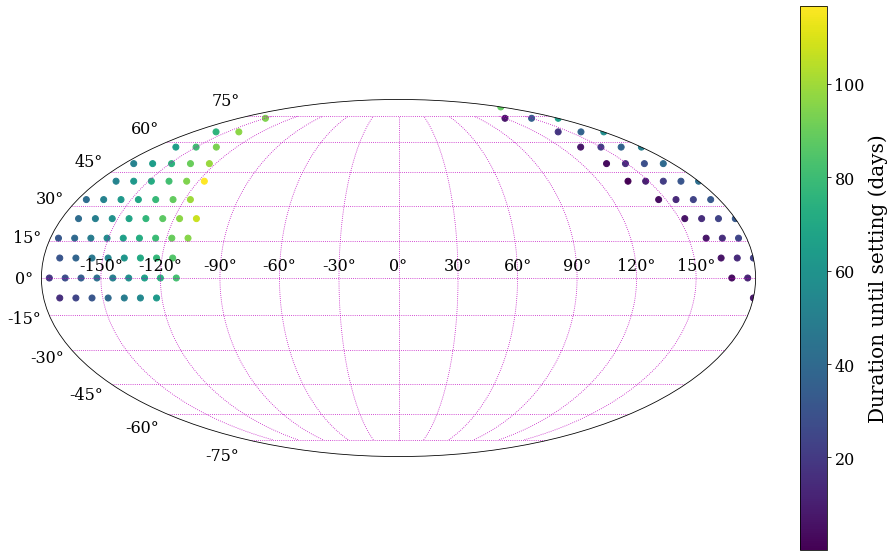

In [51]:
fav.field_set_duration();

<a id="observations"></a>
## Observations

### Add observations

The `SurveyPlanner` does not schedule fields, but observations. One observation is always associated with one field; however, multiple observations can be associated with the same field. As we want to observe all fields, we need to add observations for all fields to the database. This is done below. We can add multiple observations at the same time. They can either all have the same exposure times, repetitions, and filter selection or different. Below we add observations for all fields in the database with the same properties.

In [4]:
db = DBConnectorSQLite('test_planner.sqlite3')

Get a list of all field IDs:

In [116]:
field_ids = list(np.array(db.get_fields())[:,0])

Add observations to the database:

In [117]:
exposure = 10.
repetitions = 6
filter_name = 'r'
db.add_observations(field_ids, exposure, repetitions, filter_name)

294 observations added to data base.


**Note:** Filters are stored in the database. Before an observation is added it is checked whether the filter exists in the database. If this is not the case, the user will be asked whether or not to add the new filter. If not, no observations are added to the database. This feature reduces to chance of typos entering the database.

In [120]:
field_id = 165
exposure = 10.
repetitions = 6
filter_name = 'X'
db.add_observations(field_id, exposure, repetitions, filter_name)

Filter 'X does not exist. Add it to data base? (y/n) n


Filter was not added to database. No observations are added either.


False

**Note:** It is possible to add multiple observations of the field to the database, e.g. when the same field should be observed in different filters, or a previous observation was of poor quality and needs to be repeated. Before an observation is added it is checked, whether an observation with the same parameters exists. If that is the case, the user is informed about how many such observations exist and how many of those are done. The user can then decide whether (a) to skip adding this observation, (b) to add it anyway, (c) to add all following observations as well without asking about them when they already exist, or (d) to skip all following observations when they exist and have not been finished yet.

In [119]:
field_id = 176
exposure = 10.
repetitions = 6
filter_name = 'r'
db.add_observations(field_id, exposure, repetitions, filter_name)

1 observation(s) with the same parameters already exist in data base. 0 out of those are finished. Add new observation anyway? (y/n, 'ALL' to add all following without asking, or 'NONE' to skip all existing observations that have not been finished). n


0 observations added to data base.


In [27]:
field_id = 176
exposure = 10.
repetitions = 6
filter_name = 'i'
db.add_observations(field_id, exposure, repetitions, filter_name)

Filter 'i does not exist. Add it to data base? (y/n) y


1 observations added to data base.


### Set observations as scheduled

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

### Set observations as finished

#### By observation ID

We can select observations by ID - either as single ID (int) or list of IDs (int) - and set them as observed:

In [17]:
observation_id = [165, 164, 184]
db.set_observed(observation_id=observation_id)

3 (out of 3) observations set as done.


We can also add dates/times when the observation was performed. These will be stored in the database as well. If no date is provided as above, the date when the observation was marked as done is automatically stored.

In [20]:
observation_id = [190, 183]
date = [Time('2022-06-01 00:00:00'), Time('2022-06-01 00:05:00')]
db.set_observed(observation_id=observation_id, date=date)

2 (out of 2) observations set as done.


Selecting an ID that does not exist in the database results in a warning:

In [22]:
observation_id = 10000
db.set_observed(observation_id=observation_id)

0 (out of 1) observations set as done.


#### By field ID

We can select observations by their associated field IDs - either a single ID (int) or a list of field IDs - and set them as observed:

In [65]:
field_id = [174, 175]
db.set_observed(field_id=field_id)

2 (out of 2) observations set as done.


When multiple observations are associated with the same field an the observation is not uniquely identified the user will be asked how to proceed:

In [66]:
field_id = 176
db.set_observed(field_id=field_id)

Multiple observations matching the criteria were found. Type 'A' to mark all as observed or select a specific observation ID:
Obs ID field ID      exp      rep   filter
------ -------- -------- -------- --------
     0      176     10.0        6        r
     1      176     10.0        6        i
Selection:  0


1 (out of 1) observations set as done.


In [67]:
field_id = [185, 177, 166]
exposure = 10.
repetitions = 6
filter_name = 'r'
db.set_observed(field_id=field_id, exposure=exposure, repetitions=repetitions, filter_name=filter_name)

3 (out of 3) observations set as done.


In [68]:
field_id = 185
exposure = 10.
repetitions = 6
filter_name = 'x'
db.set_observed(field_id=field_id, exposure=exposure, repetitions=repetitions, filter_name=filter_name)

0 (out of 0) observations set as done.


/home/skiehl/Projects/Astrophysics/Pasiphae/pasiphae-survey-planner/db.py:1112: UserWarning: No observation found with the following specifications: field ID: 185, exposure: 10.0, repetitions: 6, filter: x. Skipped.
  warnings.warn(warn_info)


### Query (non-)observed fields

Note to understand the results below: I marked 11 observations of different fields as done. One of those fields has a second, pending observations.

Now that we marked some observations as observed, we can explicitly query fields that have been observed or not.

In [6]:
db = DBConnectorSQLite('test_planner.sqlite3')

The default option `observed=None`, returns all fields for the given observatory, irregardless of whether they have been observed or not. Setting `observed=True`, returns all fields that have been observed at least once. Setting `observed=False`, returns all fields that have never been observed.

In [7]:
print(len(db.get_fields('Skinakas', observed=None)), 'fields found.')
print(len(db.get_fields('Skinakas', observed=True)), 'observed fields found.')
print(len(db.get_fields('Skinakas', observed=False)), 'non-observed fields found.')

194 fields found.
11 observed fields found.
183 non-observed fields found.


Alternatively (or additionally), we can use the `pending` keyword, to query fields that have (no) pending observations associated.
The default option `pending=None`, returns all fields for the given observatory, irregardless of whether there are observations associated with this field or not. Setting `pending=True`, returns all fields that have at least one pending observation. Setting `pending=False`, returns all fields that have no pending observations.

In [56]:
print(len(db.get_fields('Skinakas', pending=None)), 'fields found.')
print(len(db.get_fields('Skinakas', pending=True)), 'fields found with pending observations.')
print(len(db.get_fields('Skinakas', pending=False)), 'fields found without pending observations.')

194 fields found.
184 fields found with pending observations.
10 fields found without pending observations.


Similarly, when we query observable fields during a night (or for a given time) from the `SurveyPlanner`, we can limit the results to (non-) observed fields and/or fields with/without associated pending observations. Different combinations are shown below:

In [49]:
surveyplanner = SurveyPlanner('test_planner.sqlite3')

In [68]:
night = Time('2022-05-15')

In [69]:
print(len(surveyplanner.get_observable_fields('Skinakas', night=night, active=True)), 'currently observable fields.')

150 currently observable fields.


In [74]:
print(len(surveyplanner.get_observable_fields('Skinakas', night=night, observed=False, active=True)),
      'currently observable fields, not observed yet.')

139 currently observable fields, not observed yet.


In [75]:
print(len(surveyplanner.get_observable_fields('Skinakas', night=night, observed=True, active=True)),
      'currently observable fields, observed already.')

11 currently observable fields, observed already.


In [72]:
print(len(surveyplanner.get_observable_fields('Skinakas', night=night, pending=True, active=True)),
      'currently observable fields with pending observations.')

140 currently observable fields with pending observations.


In [73]:
print(len(surveyplanner.get_observable_fields('Skinakas', night=night, pending=False, active=True)),
      'currently observable fields without pending observations.')

10 currently observable fields without pending observations.


In [78]:
print(len(surveyplanner.get_observable_fields('Skinakas', night=night, observed=True, pending=True, active=True)),
      'currently observable fields, observed already, yet with pending observation.')

1 currently observable fields, observed already, yet with pending observation.


### Visualize observed fields

In [88]:
surveyplanner = SurveyPlanner('test_planner.sqlite3')
fields = surveyplanner.get_fields(active=True)

In [106]:
fov = viz.FieldObservationVisualizer(fields)

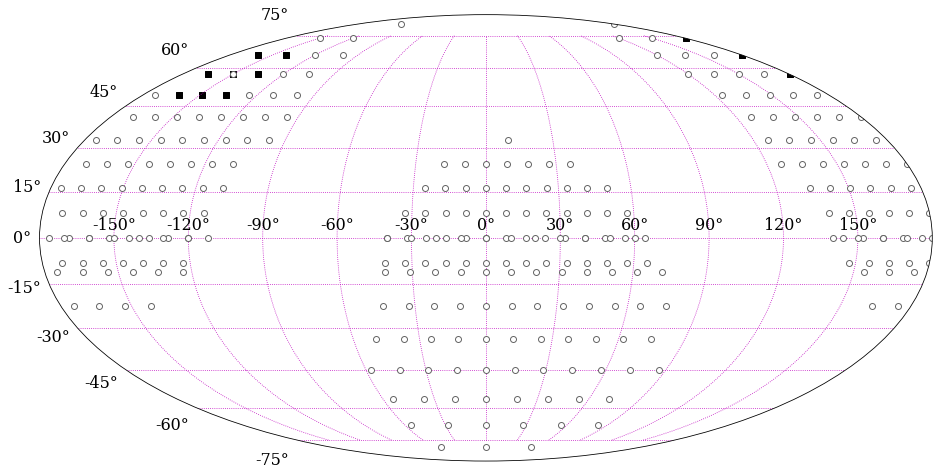

In [107]:
fov.field_status();

<a id="survey_strategy"></a>
## Survey strategy

### Identifying neighbouring fields

To apply the selection criterion that ensures the coherence of the sky coverage we need to know the completion rate of the surrounding fields for each field that is suitable for observation. For that we need to know how many neighbouring fields a field has and how many of those neighboring fields do not have pending observations, i.e. are finished.

In `Develop_Field_Neighbors.ipynb` I tested to identify field neighbors a priori or on-the-fly with different approaches. The computitionally most efficient approach is the on-the-fly identification with a brute-force python/astropy implementation.

The identification of neighbors and various counting options are implemented in the method `count_neighbors()`.

In [4]:
surveyplanner = SurveyPlanner('test.sqlite3')

We set a radius within fields are counted as neighbors:

In [5]:
radius = 20 * u.deg

First, we select a single field. We set the radius and the field ID as arguments and get the count of all field neighbors. By setting the optional argument `pending=False` we count only fields that do not have pending observations associated with them. The ratio of both counts gives us the neighhborhood completion rate:

In [6]:
field_id = 176

In [7]:
count_all = surveyplanner.count_neighbors(radius, field_id)
print(f'Count of all neighbors:      {count_all:10d}')

count_finished = surveyplanner.count_neighbors(radius, field_id, pending=False)
print(f'Count of finished neighbors: {count_finished:10d}')

print(f'Fractional neighborhood completion: {count_finished/count_all*100:3.0f} %')

Count of all neighbors:              17
Count of finished neighbors:          9
Fractional neighborhood completion:  53 %


Try two other fields:

In [8]:
field_id = 190

In [9]:
count_all = surveyplanner.count_neighbors(radius, field_id)
print(f'Count of all neighbors:      {count_all:10d}')

count_finished = surveyplanner.count_neighbors(radius, field_id, pending=False)
print(f'Count of finished neighbors: {count_finished:10d}')

print(f'Fractional neighborhood completion: {count_finished/count_all*100:3.0f} %')

Count of all neighbors:              14
Count of finished neighbors:          5
Fractional neighborhood completion:  36 %


In [10]:
field_id = 194

In [11]:
count_all = surveyplanner.count_neighbors(radius, field_id)
print(f'Count of all neighbors:      {count_all:10d}')

count_finished = surveyplanner.count_neighbors(radius, field_id, pending=False)
print(f'Count of finished neighbors: {count_finished:10d}')

print(f'Fractional neighborhood completion: {count_finished/count_all*100:3.0f} %')

Count of all neighbors:               9
Count of finished neighbors:          3
Fractional neighborhood completion:  33 %


Second, the `count_neighbors()` method gives us several other options. I am not demonstrating them all here, but give a brief description:

We can count only field that are associated with a specific observatory by setting the `observatory` argument. This gives us two options in the overlappig region around the equator where both telescopes can observe. Either we consider the North- and South-Survey in the sky coverage coherence by not setting the `observatory`argument or we keep both independent, thus, e.g. for the Skinakas survey planning only Skinakas associated fields are considered as neighbors for the sky coverage coherence.

We can also count only observed field by setting `observed=True` or count fields that have never been observed by setting `observed=False`. 

The `pending` argument, used already above, allows us to count only field that either have at least one (`pending=True`) of have no (`pending=False`) observations associated with them.

As for all querying methods by default we are limited to active fields (`active=True`), but could also query only non-active fields (`active=False`) or all fields independent of whether they are active or not (`active=None`); the active fields are the only ones of interest, therefore `active=True` is the default.

#### Note on the neighbor counts above

Fields 194, 195, 196 have decreasing number of neighbors, specifically compared to 176 and 190 the count of neighbors is low. The reason is that we do not cover the full sky. The Galactic plane is avoided and that results in fewer neighbors for specific fields. 

This is demonstrated below. We use the `FieldObservationVisualizer()` from the `visualization` module to show the status of all fields. In addition we select a field, get the IDs of all neighbors by setting `return_neighbor_ids=True` in `_count_neighbors()`. And we highlight the selected field and its neighbors in the plots. Note that the `return_neighbor_ids` argument is not implemented in the public method `count_neighbors()`, because this feature is not required in the use of the survey planner.

In [95]:
fov = viz.FieldObservationVisualizer(fields)

In [101]:
fields = surveyplanner.get_fields(active=True)

Select one field close to Galactic plane and highlight its neighbors:

In [178]:
field_id = 170
count, neighbor_ids = surveyplanner._count_neighbors(radius, field_id, return_neighbor_ids=True)
print(f'Neighbors: {count}')

Neighbors: 10


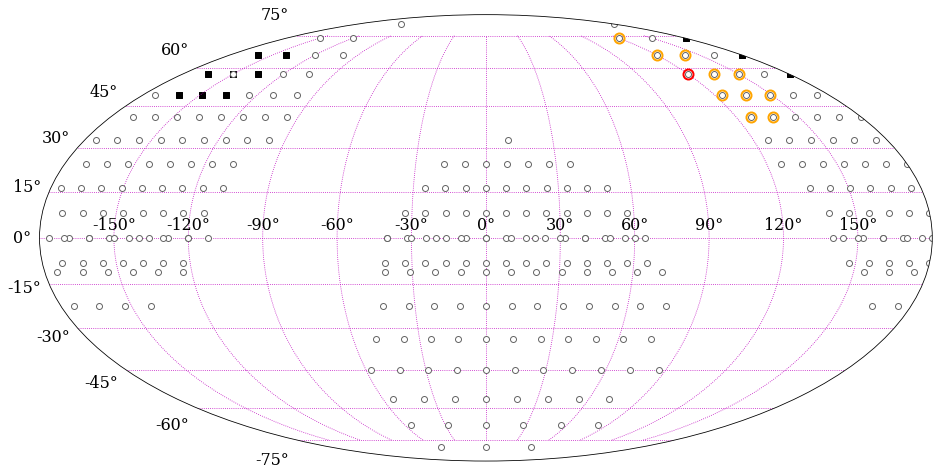

In [177]:
fig, ax = fov.field_status()

field = surveyplanner.get_field_by_id(field_id)
field_ra = field.center_ra.rad
field_ra = field_ra if field_ra <= np.pi else field_ra - 2. * np.pi
field_dec = field.center_dec.rad

ax.plot([field_ra], [field_dec], marker='o', ms=10, mfc='None', mec='r', mew=2)

for fid in neighbor_ids:
    field = surveyplanner.get_field_by_id(fid)
    field_ra = field.center_ra.rad
    field_ra = field_ra if field_ra <= np.pi else field_ra - 2. * np.pi
    field_dec = field.center_dec.rad
    
    ax.plot([field_ra], [field_dec], marker='o', ms=10, mfc='None', mec='orange', mew=2)

Select one field far from the Galactic plane and highlight its neighbors:

In [180]:
field_id = 1
count, neighbor_ids = surveyplanner._count_neighbors(radius, field_id, return_neighbor_ids=True)
print(f'Neighbors: {count}')

Neighbors: 21


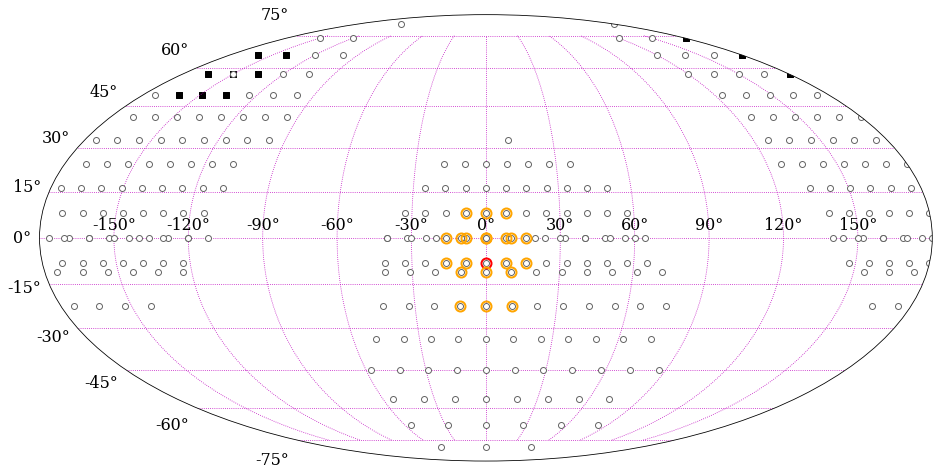

In [181]:
fig, ax = fov.field_status()

field = surveyplanner.get_field_by_id(field_id)
field_ra = field.center_ra.rad
field_ra = field_ra if field_ra <= np.pi else field_ra - 2. * np.pi
field_dec = field.center_dec.rad

ax.plot([field_ra], [field_dec], marker='o', ms=10, mfc='None', mec='r', mew=2)

for fid in neighbor_ids:
    field = surveyplanner.get_field_by_id(fid)
    field_ra = field.center_ra.rad
    field_ra = field_ra if field_ra <= np.pi else field_ra - 2. * np.pi
    field_dec = field.center_dec.rad
    
    ax.plot([field_ra], [field_dec], marker='o', ms=10, mfc='None', mec='orange', mew=2)